<a href="https://colab.research.google.com/github/aniketrox/100-days-of-deep-learning/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from cv2 import detail_ImageFeatures
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
#Pytorch
import torch
from torch import nn
import torch.nn.functional as F

#pytorch-lightning
import pytorch_lightning as pl

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')


##reproduction of the hardsigmoid coded in tensorflow (which is not exactly the same one in Pytorch)
def hardsigmoid(T):
    T_0 = T
    T = 0.2 * T_0 + 0.5
    T[T_0 < -2.5] = 0
    T[T_0 > 2.5] = 1

    return T

##ConvLSTM - Equivalent implementation of ConvLSTM2d in pytorch
##Source : https://github.com/ndrplz/ConvLSTM_pytorch
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

        self.sigmoid = hardsigmoid

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_c, cc_o = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = self.sigmoid(cc_i)
        f = self.sigmoid(cc_f)
        c_next = f * c_cur + i * torch.tanh(cc_c)
        o = self.sigmoid(cc_o)

        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):
    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.transpose(0, 1)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvGruCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvGRU cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvGruCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.sigmoid = hardsigmoid

        self.conv1 = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=2 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

        self.conv2 = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                      out_channels=self.hidden_dim,
                      kernel_size=self.kernel_size,
                      padding=self.padding,
                      bias=self.bias)


    def forward(self, input_tensor, cur_state):
        h_cur = cur_state

        # print(h_cur)
        h_x = torch.cat([h_cur,input_tensor], dim=1)  # concatenate along channel axis

        # print('OK')
        combined_conv = self.conv1(h_x)
        cc_r, cc_u = torch.split(combined_conv, self.hidden_dim, dim=1)
        r = self.sigmoid(cc_r)
        u = self.sigmoid(cc_u)

        x_r_o_h=torch.cat([input_tensor,r*h_cur],dim=1)
        # print(x_r_o_h.size())
        combined_conv = self.conv2(x_r_o_h)

        c = nn.Tanh()(combined_conv)
        h_next = (1-u)*h_cur+u*c

        return h_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv1.weight.device)


class ConvGRU(nn.Module):
    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convgru = ConvGRU(64, 16, 3, 1, True, True, False)
        >> _, last_states = convgru(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvGRU, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvGruCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.transpose(0, 1)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvGRU
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=h)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append(h)

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


## Symmetric padding (not existing natively in Pytorch)
## Source : https://discuss.pytorch.org/t/symmetric-padding/19866/3

def reflect(x, minx, maxx):
    """ Reflects an array around two points making a triangular waveform that ramps up
    and down,  allowing for pad lengths greater than the input length """
    rng = maxx - minx
    double_rng = 2 * rng
    mod = np.fmod(x - minx, double_rng)
    normed_mod = np.where(mod < 0, mod + double_rng, mod)
    out = np.where(normed_mod >= rng, double_rng - normed_mod, normed_mod) + minx
    return np.array(out, dtype=x.dtype)

def symm_pad(im, padding):
    h, w = im.shape[-2:]
    left, right, top, bottom = padding

    x_idx = np.arange(-left, w + right)
    y_idx = np.arange(-top, h + bottom)

    x_pad = reflect(x_idx, -0.5, w - 0.5)
    y_pad = reflect(y_idx, -0.5, h - 0.5)
    xx, yy = np.meshgrid(x_pad, y_pad)
    return im[..., yy, xx]


#batch normalization equivalent to the one proposed in tensorflow
#Source : https://gluon.mxnet.io/chapter04_convolutional-neural-networks/cnn-batch-norm-scratch.html

def batch_norm(X, eps=0.001):
    # extract the dimensions
    N, C, H, W = X.shape
    device=X.device
    # mini-batch mean
    mean = X.mean(axis=(0, 2, 3)).to(device)
    # mini-batch variance
    variance = ((X - mean.view((1, C, 1, 1))) ** 2).mean(axis=(0, 2, 3)).to(device)
    # normalize
    X = (X - mean.reshape((1, C, 1, 1))) * 1.0 / torch.pow((variance.view((1, C, 1, 1)) + eps), 0.5)
    return X.to(device)


class IMTFE(nn.Module):
    # ********** IMAGE MANIPULATION TRACE FEATURE EXTRACTOR *********
    def __init__(self, in_channel=3,device=device):
        super(IMTFE, self).__init__()

        self.relu = nn.ReLU()
        self.device=device

        ## Initialisation

        self.init_conv = nn.Conv2d(in_channel, 4, 5, 1, padding=0, bias=False)

        self.BayarConv2D = nn.Conv2d(in_channel, 3, 5, 1, padding=0, bias=False)
        self.bayar_mask = (torch.tensor(np.ones(shape=(5, 5)))).to(self.device)
        self.bayar_mask[2, 2] = 0

        self.bayar_final = (torch.tensor(np.zeros((5, 5)))).to(self.device)
        self.bayar_final[2, 2] = -1

        self.SRMConv2D = nn.Conv2d(in_channel, 9, 5, 1, padding=0, bias=False)
        self.SRMConv2D.weight.data=torch.load('/content/model/IMTFEv4.pt')['SRMConv2D.weight']

        ##SRM filters (fixed)
        for param in self.SRMConv2D.parameters():
            param.requires_grad = False

        self.middle_and_last_block = nn.ModuleList([
            nn.Conv2d(16, 32, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, padding=0)]
        )

    def forward(self,x):
        _,_,H,W = x.shape

        # Normalization
        x = x / 255. * 2 - 1

        ## Image Manipulation Trace Feature Extractor

        ## **Bayar constraints**

        self.BayarConv2D.weight.data *= self.bayar_mask
        self.BayarConv2D.weight.data *= torch.pow(self.BayarConv2D.weight.data.sum(axis=(2, 3)).view(3, 3, 1, 1), -1)
        self.BayarConv2D.weight.data += self.bayar_final

        #Symmetric padding
        x = symm_pad(x, (2, 2, 2, 2))

        conv_init = self.init_conv(x)
        conv_bayar = self.BayarConv2D(x)
        conv_srm = self.SRMConv2D(x)

        first_block = torch.cat([conv_init, conv_srm, conv_bayar], axis=1)
        first_block = self.relu(first_block)

        last_block = first_block

        for layer in self.middle_and_last_block:

            if isinstance(layer, nn.Conv2d):
                last_block = symm_pad(last_block, (1, 1, 1, 1))

            last_block = layer(last_block)

        #L2 normalization
        last_block = F.normalize(last_block, dim=1, p=2)

        return last_block


class AnomalyDetector(nn.Module):
    # ********** IMAGE MANIPULATION TRACE FEATURE EXTRACTOR *********
    def __init__(self, eps=10 ** (-6),device=device,with_GRU=False):
        super(AnomalyDetector, self).__init__()

        self.eps = eps
        self.relu = nn.ReLU()
        self.device=device
        self.with_GRU=with_GRU

        # ********** LOCAL ANOMALY DETECTOR *********

        self.adaptation = nn.Conv2d(256, 64, 1, 1, padding=0, bias=False)

        self.sigma_F = nn.Parameter(torch.zeros((1, 64, 1, 1)), requires_grad=True)

        self.pool31 = nn.AvgPool2d(31, stride=1, padding=15, count_include_pad=False)
        self.pool15 = nn.AvgPool2d(15, stride=1, padding=7, count_include_pad=False)
        self.pool7 = nn.AvgPool2d(7, stride=1, padding=3, count_include_pad=False)

        if not(self.with_GRU):
            self.conv_lstm =ConvLSTM(input_dim=64,
                                    hidden_dim=8,
                                    kernel_size=(7, 7),
                                    num_layers=1,
                                    batch_first=False,
                                    bias=True,
                                    return_all_layers=False)
        else:
            self.conv_gru=ConvGRU(input_dim=64,
                                 hidden_dim=8,
                                 kernel_size=(7, 7),
                                 num_layers=1,
                                 batch_first=False,
                                 bias=True,
                                 return_all_layers=False)


        self.end = nn.Sequential(nn.Conv2d(8, 1, 7, 1, padding=3),nn.Sigmoid())


    def forward(self,IMTFE_output):
        _,_,H,W = IMTFE_output.shape

        if not(self.training):
            self.GlobalPool = nn.AvgPool2d((H, W), stride=1)
        else:
            if not hasattr(self, 'GlobalPool'):
                self.GlobalPool = nn.AvgPool2d((H, W), stride=1)

        ## Local Anomaly Feature Extraction
        X_adapt = self.adaptation(IMTFE_output)
        X_adapt = batch_norm(X_adapt)

        # Z-pool concatenation
        mu_T = self.GlobalPool(X_adapt)
        sigma_T = torch.sqrt(self.GlobalPool(torch.square(X_adapt - mu_T)))
        sigma_T = torch.max(sigma_T, self.sigma_F + self.eps)
        inv_sigma_T = torch.pow(sigma_T, -1)
        zpoolglobal = torch.abs((mu_T - X_adapt) * inv_sigma_T)

        mu_31 = self.pool31(X_adapt)
        zpool31 = torch.abs((mu_31 - X_adapt) * inv_sigma_T)

        mu_15 = self.pool15(X_adapt)
        zpool15 = torch.abs((mu_15 - X_adapt) * inv_sigma_T)

        mu_7 = self.pool7(X_adapt)
        zpool7 = torch.abs((mu_7 - X_adapt) * inv_sigma_T)

        input_rnn = torch.cat([zpool7.unsqueeze(0), zpool15.unsqueeze(0), zpool31.unsqueeze(0), zpoolglobal.unsqueeze(0)], axis=0)

        if not(self.with_GRU):
            # Conv2DLSTM
            _, output_lstm = self.conv_lstm(input_rnn)
            output_lstm = output_lstm[0][0]

            final_output = self.end(output_lstm)

        else:
            # Conv2DLSTM
            _,output_gru = self.conv_gru(input_rnn)
            output_gru = output_gru[0]

            final_output = self.end(output_gru)


        return final_output


#MantraNet (equivalent from the one coded in tensorflow at https://github.com/ISICV/ManTraNet)
class MantraNet(nn.Module):
    def __init__(self, in_channel=3, eps=10 ** (-6),device=device,with_GRU=False):
        super(MantraNet, self).__init__()

        self.eps = eps
        self.relu = nn.ReLU()
        self.device=device


        self.IMTFE=IMTFE(in_channel=in_channel,device=device)
        self.AnomalyDetector=AnomalyDetector(eps=eps,device=device,with_GRU=with_GRU)

    def forward(self, x):

        return self.AnomalyDetector(self.IMTFE(x))


##Use pre-trained weights :
def pre_trained_model(weight_path='./MantraNetv4.pt',device=device):
    model=MantraNet(device=device)
    model.load_state_dict(torch.load(weight_path))
    return model

#predict a forgery mask of an image
def check_forgery(model,img_path='./example.jpg',device=device):

    model.to(device)
    model.eval()

    im = Image.open(img_path)
    im = np.array(im)
    original_image=im.copy()

    im = torch.Tensor(im)
    im = im.unsqueeze(0)
    im = im.transpose(2, 3).transpose(1, 2)
    im = im.to(device)

    with torch.no_grad():
        final_output = model(im)

    plt.subplot(1,3,1)
    plt.imshow(original_image)
    plt.title('Original image')

    plt.subplot(1,3,2)
    plt.imshow((final_output[0][0]).cpu().detach(), cmap='gray')
    plt.title('Predicted forgery mask')

    plt.subplot(1,3,3)
    plt.imshow((final_output[0][0].cpu().detach().unsqueeze(2)>0.2)*torch.tensor(original_image))
    plt.title('Suspicious regions detected')

In [2]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 11.9 MB/s eta 0:00:00


In [9]:
%load_ext autoreload
%autoreload 2.

import os

try:
    os.chdir('./MantraNet')
except:
    pass

import matplotlib.pyplot as plt
import gc

#from mantranet import *

from pytorch_lightning import Trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### I - How to use ManTraNet in evaluation mode (using pre-trained weights) ?

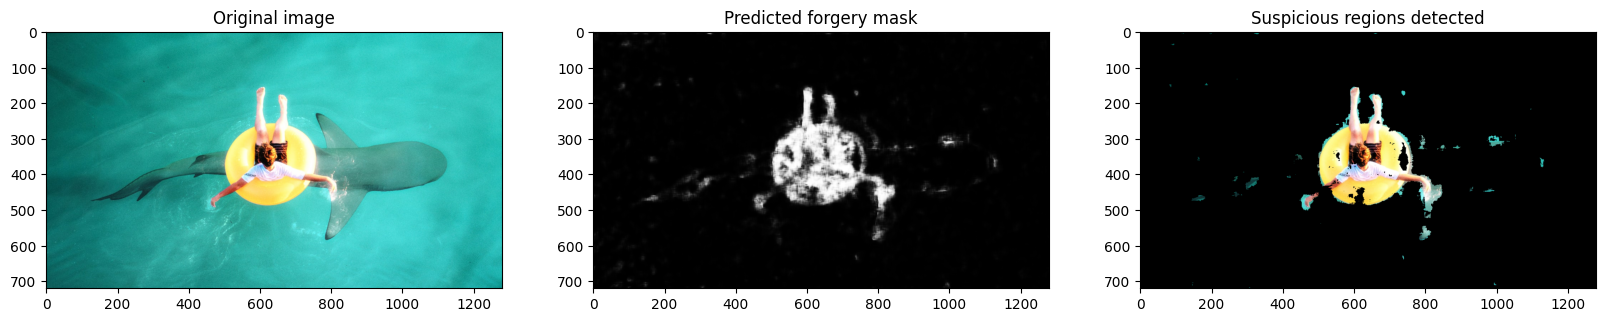

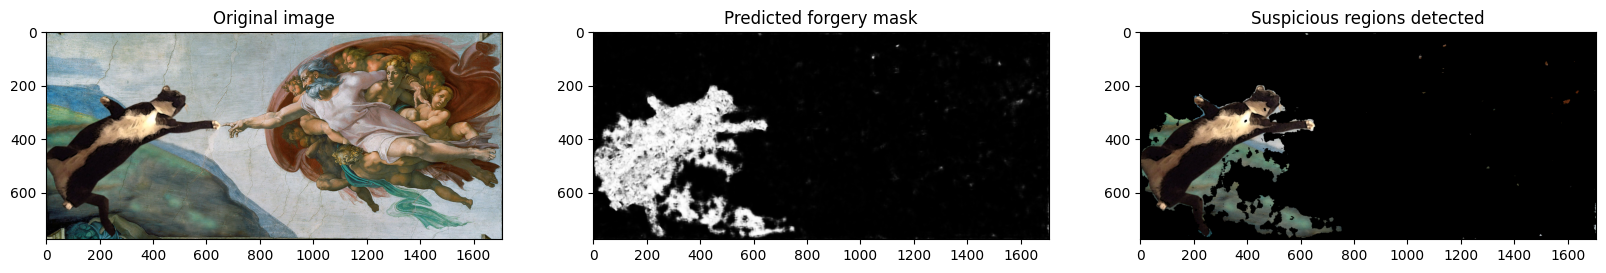

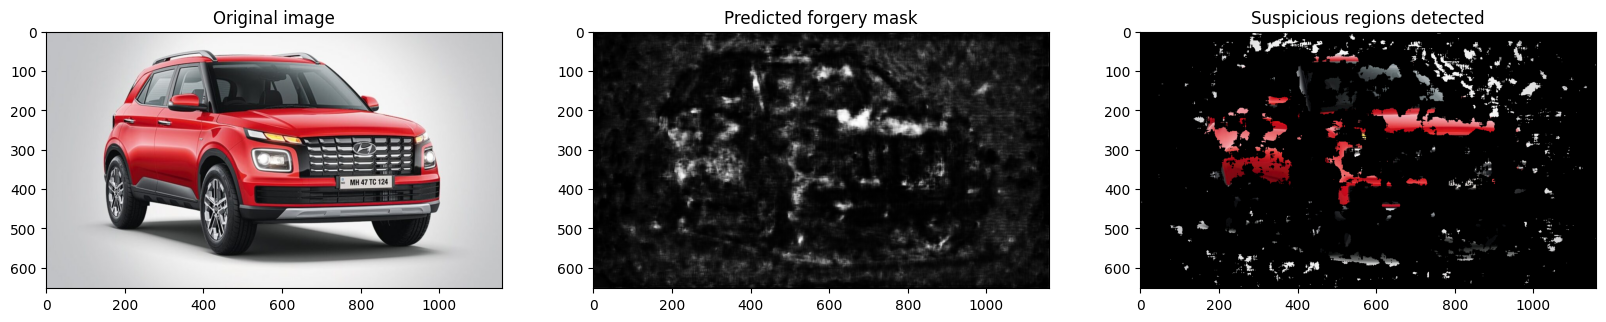

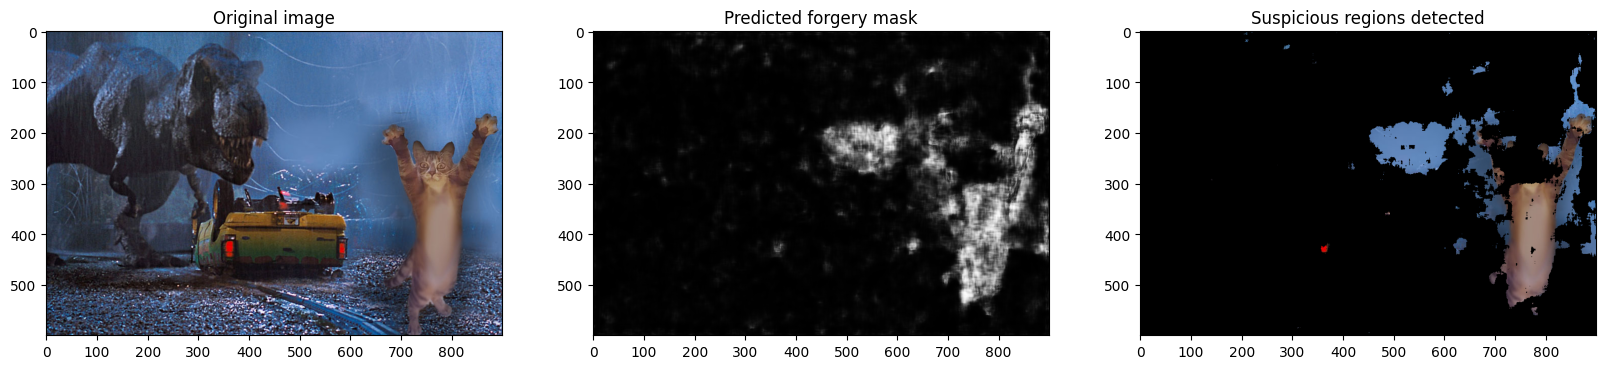

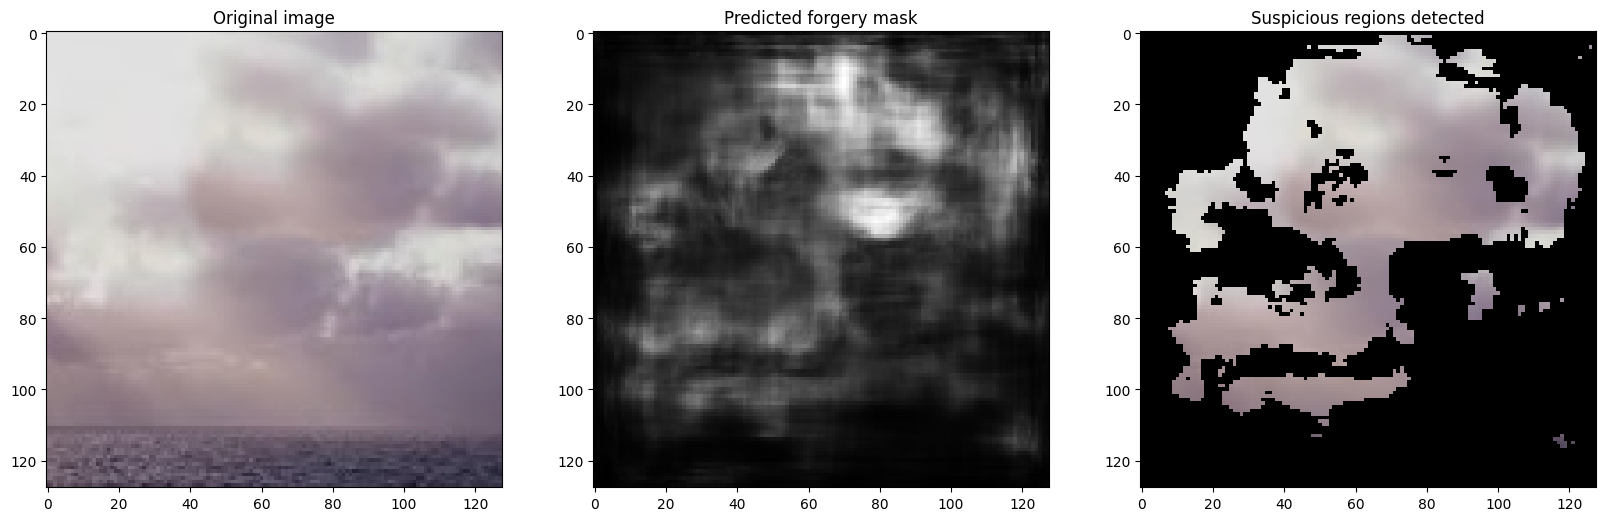

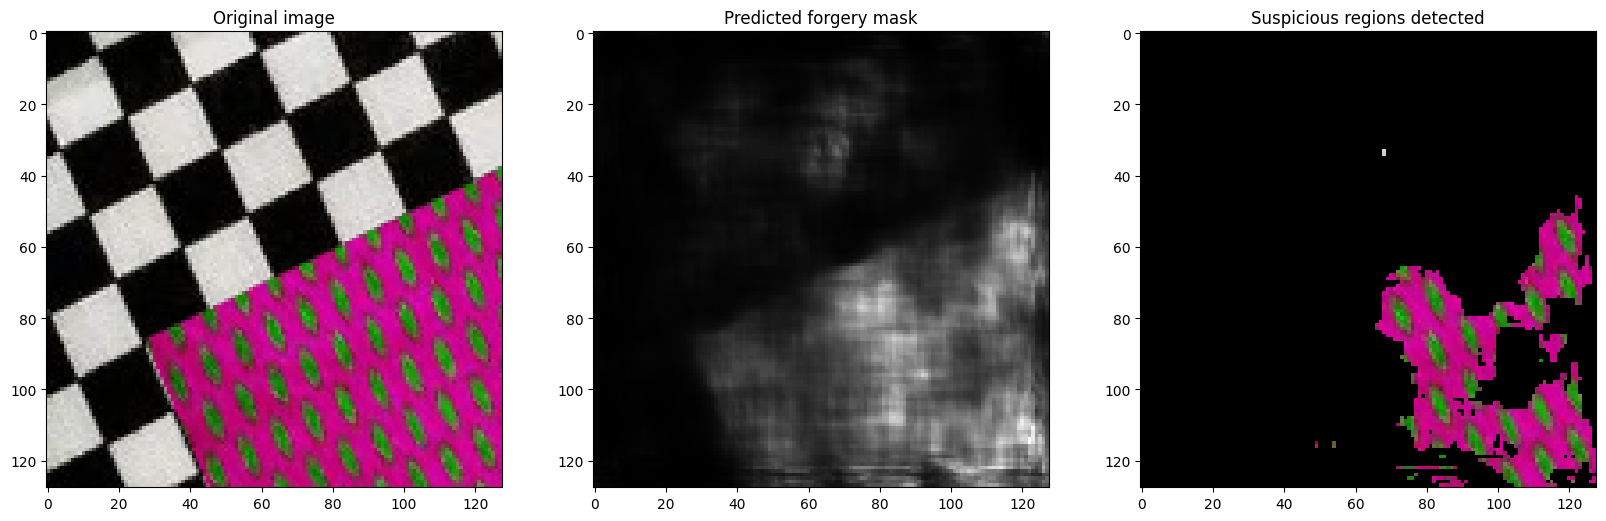

In [11]:
device='cuda' #to change if you have a GPU with at least 12Go RAM (it will save you a lot of time !)
model=pre_trained_model(weight_path='/content/model/MantraNetv4.pt',device=device)

model.eval()
for image in os.listdir('/content/demo_images'):

    plt.figure(figsize=(20,20))
    check_forgery(model,img_path=f'/content/demo_images/{image}',device=device)

### II - How to train ManTraNet from the pre-trained weights ?

Following the philosophy of the paper, in order to build MantraNet one should train the Feature Extractor and the Anomaly Detector separately with specific datasets and then, compose them to finally obtain MantraNet in evaluation mode.

The authors gave details about their experimental protocol in Section **2.3** of their article.

![](https://i.imgur.com/7vVf629.png)

However, please not that some data are not shared and that's why it is not so easy to reproduce their training.

To Simplify you things, I divided the MantraNet network into two networks that you can train separately like the authors did (IMTFE and AnomalyDetector)

In [12]:
model

MantraNet(
  (relu): ReLU()
  (IMTFE): IMTFE(
    (relu): ReLU()
    (init_conv): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (BayarConv2D): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (SRMConv2D): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (middle_and_last_block): ModuleList(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (7): ReLU()
      (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (9): ReLU()
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (11): ReLU()
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (13): ReLU()
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (15): ReLU()
      (16): Co